# 🛡️ Malicious Domain Detection via RDAP Data Analysis and Transformer Modeling

## Brief Description

This notebook focuses on selecting the proper features for the detection of **malicious domains** (phishing, malware, etc.) using metadata from RDAP records. The workflow is organized into two main phases:

- Phase 1: RDAP JSON Preprocessing and Flattening

- Phase 2: Textual Feature Analysis for Model Input

---

## ✅ Outcome

By the end of this notebook:
- You will have a clean, analysis-ready RDAP dataset.
- You will understand which RDAP fields are most discriminative.
- You’ll be ready to feed selected fields into a transformer model to classify domains as **malicious** or **benign** with improved efficiency.

---


# Phase 1: RDAP JSON Preprocessing and Flattening

**Goal:**  
Prepare RDAP data for analysis by transforming MongoDB-exported JSON files into a structured tabular format.

**Input Format:**
- A JSON file where each line represents a document containing:
  - `"domain_name"`: the domain string.
  - `"rdap"`: a nested object with registration data.

**Processing Steps:**
1. Load each line from the JSON file into memory.
2. Flatten the nested `"rdap"` object using `pandas.json_normalize`.
3. Drop the MongoDB-generated `"_id"` field.
4. Optionally, clean up column names by removing the `rdap.` prefix.

**Output:**
A `pandas.DataFrame` where each row represents a domain, and columns include all flattened RDAP metadata fields — ready for further analysis.


In [1]:
import json
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import HTML
from typing import Optional, List, Dict
from scipy.stats import chi2_contingency

In [2]:


def render_dataframe(df, max_rows=100, max_cols=50):
    styles = [
        dict(selector="th", props=[("max-width", "200px")]),
        dict(selector="td", props=[("max-width", "200px"), ("overflow", "auto"), ("text-overflow", "ellipsis")]),
    ]
    return HTML(df.head(max_rows).style.set_table_styles(styles).set_table_attributes('style="display:inline-block;overflow:auto;max-height:500px;"').to_html())

def read_rdap_json_file(file_path: str) -> pd.DataFrame:
    # Read the JSON file line by line
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    # Flatten the JSON structure; each nested key from 'rdap' becomes a column like 'rdap.handle', etc.
    df = pd.json_normalize(data, sep='.')

    # Drop _id columns 
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')])

    # Remove the "rdap." prefix from column names for clarity
    df.columns = [col.replace('rdap.', '') for col in df.columns]
    return df 

# Construct the path to the JSON file relative to this script's location.
script_path = Path.cwd()
# Go up 3 levels to the project root (from transformers/data -> transformers -> project_root)
project_root = script_path.parent.parent

In [3]:
def _sample_jsonl_lines(file_path: str, sample_size: int, total_lines: int, seed: int) -> List[Dict]:
    """
    Randomly samples lines from a JSONL file using a 2-pass strategy.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int): Number of lines to sample.
        total_lines (int): Total number of lines in the file.
        seed (int): Random seed for reproducibility.

    Returns:
        List[Dict]: List of sampled JSON objects.
    """
    random.seed(seed)
    selected_indices = set(random.sample(range(total_lines), sample_size))
    data = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i in selected_indices:
                data.append(json.loads(line))
            if len(data) >= sample_size:
                break  # Optional: early exit

    return data

def read_rdap_json_file_to_df(file_path: str, sample_size: Optional[int] = None, seed: int = 42) -> pd.DataFrame:
    """
    Reads a JSONL RDAP file and returns a flattened pandas DataFrame.
    If sample_size is provided and smaller than total lines, randomly samples those lines.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int, optional): Number of records to sample. If None or exceeds file size, loads full file.
        seed (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Flattened DataFrame with 'domain_name' and RDAP fields.
    """
    with open(file_path, 'r') as f:
        total_lines = sum(1 for _ in f)

    if sample_size is None or sample_size >= total_lines:
        with open(file_path, 'r') as f:
            data = [json.loads(line) for line in f]
    else:
        data = _sample_jsonl_lines(file_path, sample_size, total_lines, seed)

    df = pd.json_normalize(data, sep='.')
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')], errors='ignore')
    df.columns = [col.replace('rdap.', '') for col in df.columns]

    return df


### Benign

In [4]:
benign_file_path = project_root / "datasets" / "benign" / "benign_2312_anonymized_rdap_2024.json"
benign_df = read_rdap_json_file_to_df(benign_file_path, sample_size=160_000)
render_dataframe(benign_df)

,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrant,entities.abuse,entities.admin,entities.registrar,nameservers,status,registration_date,expiration_date,entities.technical,entities.administrative,entities.billing,dnssec,rdap,last_changed_date,entities.sponsor,entities.zone,entities.tech,entities.reseller
0,00000fs3085d.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0000100b00e9.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0000100q012c.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0000102n02c4.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0000102n02d5.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,0000102n03d3.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,0000102n0434.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,000010560066.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,0000105600be.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,000010640021.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [5]:
benign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   domain_name              160000 non-null  object 
 1   handle                   104921 non-null  object 
 2   name                     104921 non-null  object 
 3   whois_server             104921 non-null  object 
 4   terms_of_service_url     104921 non-null  object 
 5   copyright_notice         104921 non-null  object 
 6   description              104921 non-null  object 
 7   last_changed_date.$date  87207 non-null   object 
 8   registration_date.$date  96981 non-null   object 
 9   expiration_date.$date    91816 non-null   object 
 10  url                      104921 non-null  object 
 11  entities.registrant      103373 non-null  object 
 12  entities.abuse           99417 non-null   object 
 13  entities.admin           63215 non-null   object 
 14  enti

### Malware

In [6]:
# Now build the path to the JSON file in datasets/malware/
# json_file_path = project_root / "datasets" / "phishing" / "phishing_strict_rdap_2024.json"
json_file_path = project_root / "datasets" / "malware" / "malware_strict_rdap_2024.json"
malware_df = read_rdap_json_file_to_df(json_file_path)
render_dataframe(malware_df)

,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,entities.admin,expiration_date,rdap,last_changed_date,entities.administrative,entities.technical,entities.billing,registration_date,entities.sponsor,entities.reseller,entities.tech,entities.a,entities.d,entities.m,entities.i,entities.n,entities.s,entities.t,entities.r,entities.v,entities.e,entities.c,entities.h,entities.l,entities.b,entities.g,entities.zone
0,irradiateher.com,2740314140_DOMAIN_COM-VRSN,IRRADIATEHER.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2023-10-25T09:40:06Z,2022-11-23T13:12:23Z,2024-11-23T13:12:23Z,https://rdap.verisign.com/com/v1/domain/IRRADIATEHER.COM,"[{'handle': '48', 'type': 'entity', 'name': 'eNom, LLC'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['NS1.PUBLICDNSSERVICE.COM', 'NS2.PUBLICDNSSERVICE.COM', 'NS3.PUBLICDNSSERVICE.COM', 'NS4.PUBLICDNSSERVICE.COM']",['client transfer prohibited'],False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,eloquentcs.com,1808171119_DOMAIN_COM-VRSN,ELOQUENTCS.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2023-06-16T09:46:02Z,2013-06-13T16:04:43Z,2024-06-13T16:04:43Z,https://rdap.verisign.com/com/v1/domain/ELOQUENTCS.COM,"[{'handle': '146', 'type': 'entity', 'name': 'GoDaddy.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'abuse@godaddy.com'}]","['NS59.DOMAINCONTROL.COM', 'NS60.DOMAINCONTROL.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,www.neutralsystemsolution.space,,neutralsystemsolution.space,,,,[],2023-08-31T17:10:49Z,2023-06-02T08:35:48Z,2024-06-02T23:59:59Z,,[{'name': 'PDR Ltd. d/b/a PublicDomainRegistry.com'}],[{'email': ''}],"['NS1.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM', 'NS2.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM']",['client transfer prohibited'],nan,[{'name': 'none'}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,www.drshiwanijainpainclinic.com,,drshiwanijainpainclinic.com,,,,[],2022-10-13T18:35:46Z,2021-08-31T12:20:02Z,2024-08-31T12:20:02Z,,"[{'name': 'GoDaddy.com, LLC'}]",[{'email': ''}],"['NS1.DNS-PARKING.COM', 'NS2.DNS-PARKING.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",nan,"[{'name': 'Domains By Proxy, LLC'}]",[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,mkt9136.com,2162099471_DOMAIN_COM-VRSN,MKT9136.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2023-08-11T09:31:50Z,2017-09-12T15:20:17Z,2024-09-12T15:20:17Z,https://rdap.verisign.com/com/v1/domain/MKT9136.COM,"[{'handle': '292', 'type': 'entity', 'name': 'MarkMonitor Inc.'}]","[{'type': 'entity', 'name': '', 'email': 'abusecomplaints@markmonitor.com'}]","['NS1.ACOUSTIC-ADM.COM', 'NS2.ACOUSTIC-ADM.COM', 'NS3.ACOUSTIC-ADM.COM', 'NS4.ACOUSTIC-ADM.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,www.ninjacondoms.com,,ninjacondoms.com,,,,[],2023-07-28T20:28:00Z,2005-10-22T18:20:32Z,2024-10-22T18:20:32Z,,"[{'name': 'OnlineNIC, Inc.'}]",[{'email': ''}],"['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']","['client delete prohibited', 'client transfer prohibited']",nan,[{'name': ''}],[{'name': ''}],nan,na

In [7]:
malware_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100809 entries, 0 to 100808
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   domain_name              100809 non-null  object 
 1   handle                   75853 non-null   object 
 2   name                     75853 non-null   object 
 3   whois_server             75853 non-null   object 
 4   terms_of_service_url     75853 non-null   object 
 5   copyright_notice         75853 non-null   object 
 6   description              75853 non-null   object 
 7   last_changed_date.$date  70479 non-null   object 
 8   registration_date.$date  73628 non-null   object 
 9   expiration_date.$date    72260 non-null   object 
 10  url                      75853 non-null   object 
 11  entities.registrar       74393 non-null   object 
 12  entities.abuse           72985 non-null   object 
 13  nameservers              75853 non-null   object 
 14  stat

# Phase 2: Textual Feature Analysis for Model Input

**Goal:**  
Identify the most informative **textual RDAP fields** for input into a transformer-based model for malicious domain classification.

**Steps:**
1. **Handle missing values**
2. **Text Field Extraction:**  
   Collect all string-based fields from the flattened DataFrame.
3. **Feature Engineering:**  
   For each field, compute numerical representations such as:
   - String length
   - Character entropy
   - Alphanumeric ratios
   - Word count, etc.
4. **Statistical Evaluation:**  
   - Visualize distributions (histograms, KDEs).
   - Perform hypothesis testing (e.g., t-test, Mann-Whitney U) to assess significance between malicious and benign domains.
5. **Feature Selection:**  
   Rank and select fields that show strong statistical signals or unique distribution patterns across classes.


## Handling of missing values

### Columns with any NaN (missing values)
Before hadnling the Nan values, it is clear that some columns appear that they are not empty, because they do not contain NaN values. But this is false, because by analyzing the columns, it is clear that some of them contain empty strings '' or empty lists '[]'. Therefore, for better analysis will be these values replaced by NaN.

In [8]:
# Replace empty strings or strings with only whitespace with NaN
benign_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
malware_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

def convert_empty_list(val):
    if isinstance(val, list) and len(val) == 0:
        return np.nan
    return val

# Apply this function to every cell in the DataFrame
benign_df[:] = benign_df.applymap(convert_empty_list)
malware_df[:] = malware_df.applymap(convert_empty_list)

/tmp/ipykernel_1153312/2503607035.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  benign_df[:] = benign_df.applymap(convert_empty_list)
/tmp/ipykernel_1153312/2503607035.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  malware_df[:] = malware_df.applymap(convert_empty_list)


In [9]:
# Benign
nan_columns = benign_df.columns[benign_df.isna().any()].tolist()
print("Benign:")
print(f"Number of columns containing any NaN value: {len(nan_columns)}")
print(f"Total number of columns: {len(benign_df.columns.to_list())}")
print("---------------------------------------------------------------")
#Phishing
nan_columns = malware_df.columns[malware_df.isna().any()].tolist()
print("Phishing:")
print(f"Number of columns containing any NaN value: {len(nan_columns)}")
print(f"Total number of columns: {len(malware_df.columns.to_list())}")

Benign:
Number of columns containing any NaN value: 28
Total number of columns: 29
---------------------------------------------------------------
Phishing:
Number of columns containing any NaN value: 43
Total number of columns: 44


### Columns That Are Fully Empty (All Values Are NaN)
These columns can be fully dropped

In [10]:
# Benign
fully_nan_benign = benign_df.columns[benign_df.isna().all()].tolist()
print("Benign:")
print("Columns with only NaN values:", fully_nan_benign)
print("---------------------------------------------------------------")

# Phishing
fully_nan_phishing = malware_df.columns[malware_df.isna().all()].tolist()
print("Phishing:")
print("Columns with only NaN values:", fully_nan_phishing)

Benign:
Columns with only NaN values: ['registration_date', 'expiration_date', 'rdap', 'last_changed_date']
---------------------------------------------------------------
Phishing:
Columns with only NaN values: ['expiration_date', 'rdap', 'last_changed_date', 'registration_date']


In [11]:
# Benign
print("Benign:") 
print("Before:", benign_df.shape)
benign_df.drop(columns=fully_nan_benign, inplace=True, errors="ignore")
print("After:", benign_df.shape)
print("---------------------------------------------------------------")
# Phishing
print("Phishing:") 
print("Before:", malware_df.shape)
malware_df.drop(columns=fully_nan_phishing, inplace=True, errors="ignore")
print("After:", malware_df.shape)

Benign:
Before: (160000, 29)
After: (160000, 25)
---------------------------------------------------------------
Phishing:
Before: (100809, 44)
After: (100809, 40)


In [12]:
missing_counts = malware_df.isna().sum()
print(missing_counts[missing_counts > 0])

handle                      51508
name                        24956
whois_server                92569
terms_of_service_url        54611
copyright_notice           100702
description                100781
last_changed_date.$date     30330
registration_date.$date     27181
expiration_date.$date       28549
url                         53516
entities.registrar          26416
entities.abuse              27824
nameservers                 25793
status                      27922
dnssec                      51190
entities.registrant         59478
entities.admin              74571
entities.administrative     86293
entities.technical          86313
entities.billing            93261
entities.sponsor           100325
entities.reseller          100771
entities.tech              100805
entities.a                 100808
entities.d                 100808
entities.m                 100808
entities.i                 100808
entities.n                 100808
entities.s                 100808
entities.t    

In [13]:
# Option: Check columns starting with "entities." in malware_df
suspicious_cols = [c for c in malware_df.columns if c.startswith("entities.")]
for col in suspicious_cols:
    non_null_count = malware_df[col].notna().sum()
    if non_null_count == 1:
        print(f"Column: {col}")
        row_index = malware_df[malware_df[col].notna()].index
        print("Row index with non-null value:", row_index.tolist())
        print(malware_df.loc[row_index, col])
        print("---")

print("Entire row:")
print(malware_df.loc[row_index])

Column: entities.a
Row index with non-null value: [22374]
22374    [{'handle': 'PRIVATE', 'type': 'entity'}]
Name: entities.a, dtype: object
---
Column: entities.d
Row index with non-null value: [22374]
22374    [{'handle': 'PRIVATE', 'type': 'entity'}]
Name: entities.d, dtype: object
---
Column: entities.m
Row index with non-null value: [22374]
22374    [{'handle': 'PRIVATE', 'type': 'entity'}]
Name: entities.m, dtype: object
---
Column: entities.i
Row index with non-null value: [22374]
22374    [{'handle': 'PRIVATE', 'type': 'entity'}]
Name: entities.i, dtype: object
---
Column: entities.n
Row index with non-null value: [22374]
22374    [{'handle': 'PRIVATE', 'type': 'entity'}]
Name: entities.n, dtype: object
---
Column: entities.s
Row index with non-null value: [22374]
22374    [{'handle': 'PRIVATE', 'type': 'entity'}]
Name: entities.s, dtype: object
---
Column: entities.t
Row index with non-null value: [22374]
22374    [{'handle': 'PRIVATE', 'type': 'entity'}]
Name: entities.t, dty

In [14]:
common_columns = set(malware_df.columns) & set(benign_df.columns)
print("Number of common columns:", len(common_columns))
print("Common columns:")
print(common_columns)

different_columns = set(malware_df.columns) - set(benign_df.columns)
print("Number of different columns:", len(different_columns))
print("Different columns:")
print(different_columns)

Number of common columns: 25
Common columns:
{'entities.tech', 'status', 'last_changed_date.$date', 'entities.technical', 'entities.abuse', 'terms_of_service_url', 'handle', 'url', 'entities.administrative', 'entities.zone', 'domain_name', 'entities.registrar', 'dnssec', 'entities.reseller', 'expiration_date.$date', 'nameservers', 'entities.sponsor', 'entities.billing', 'entities.registrant', 'entities.admin', 'registration_date.$date', 'copyright_notice', 'description', 'name', 'whois_server'}
Number of different columns: 15
Different columns:
{'entities.d', 'entities.l', 'entities.h', 'entities.c', 'entities.s', 'entities.e', 'entities.a', 'entities.b', 'entities.i', 'entities.n', 'entities.t', 'entities.g', 'entities.r', 'entities.m', 'entities.v'}


In [15]:
# Assuming common_columns is your set of column names
malware_df.drop(columns=different_columns, inplace=True)
render_dataframe(malware_df)

,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,entities.admin,entities.administrative,entities.technical,entities.billing,entities.sponsor,entities.reseller,entities.tech,entities.zone
0,irradiateher.com,2740314140_DOMAIN_COM-VRSN,IRRADIATEHER.COM,nan,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,nan,nan,2023-10-25T09:40:06Z,2022-11-23T13:12:23Z,2024-11-23T13:12:23Z,https://rdap.verisign.com/com/v1/domain/IRRADIATEHER.COM,"[{'handle': '48', 'type': 'entity', 'name': 'eNom, LLC'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['NS1.PUBLICDNSSERVICE.COM', 'NS2.PUBLICDNSSERVICE.COM', 'NS3.PUBLICDNSSERVICE.COM', 'NS4.PUBLICDNSSERVICE.COM']",['client transfer prohibited'],False,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,eloquentcs.com,1808171119_DOMAIN_COM-VRSN,ELOQUENTCS.COM,nan,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,nan,nan,2023-06-16T09:46:02Z,2013-06-13T16:04:43Z,2024-06-13T16:04:43Z,https://rdap.verisign.com/com/v1/domain/ELOQUENTCS.COM,"[{'handle': '146', 'type': 'entity', 'name': 'GoDaddy.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'abuse@godaddy.com'}]","['NS59.DOMAINCONTROL.COM', 'NS60.DOMAINCONTROL.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,www.neutralsystemsolution.space,nan,neutralsystemsolution.space,nan,nan,nan,nan,2023-08-31T17:10:49Z,2023-06-02T08:35:48Z,2024-06-02T23:59:59Z,nan,[{'name': 'PDR Ltd. d/b/a PublicDomainRegistry.com'}],[{'email': ''}],"['NS1.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM', 'NS2.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM']",['client transfer prohibited'],nan,[{'name': 'none'}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan
3,www.drshiwanijainpainclinic.com,nan,drshiwanijainpainclinic.com,nan,nan,nan,nan,2022-10-13T18:35:46Z,2021-08-31T12:20:02Z,2024-08-31T12:20:02Z,nan,"[{'name': 'GoDaddy.com, LLC'}]",[{'email': ''}],"['NS1.DNS-PARKING.COM', 'NS2.DNS-PARKING.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",nan,"[{'name': 'Domains By Proxy, LLC'}]",[{'name': ''}],nan,nan,nan,nan,nan,nan,nan
4,mkt9136.com,2162099471_DOMAIN_COM-VRSN,MKT9136.COM,nan,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,nan,nan,2023-08-11T09:31:50Z,2017-09-12T15:20:17Z,2024-09-12T15:20:17Z,https://rdap.verisign.com/com/v1/domain/MKT9136.COM,"[{'handle': '292', 'type': 'entity', 'name': 'MarkMonitor Inc.'}]","[{'type': 'entity', 'name': '', 'email': 'abusecomplaints@markmonitor.com'}]","['NS1.ACOUSTIC-ADM.COM', 'NS2.ACOUSTIC-ADM.COM', 'NS3.ACOUSTIC-ADM.COM', 'NS4.ACOUSTIC-ADM.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,www.ninjacondoms.com,nan,ninjacondoms.com,nan,nan,nan,nan,2023-07-28T20:28:00Z,2005-10-22T18:20:32Z,2024-10-22T18:20:32Z,nan,"[{'name': 'OnlineNIC, Inc.'}]",[{'email': ''}],"['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']","['client delete prohibited', 'client transfer prohibited']",nan,[{'name': ''}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan
6,gabbyloans.com,2449606030_DOMAIN_COM-VRSN,GABBYLOANS.COM,nan,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,nan,nan,2019-10-30T18:13:37Z,2019-10-30T17:42:10Z,2024-10-30T17:42:10Z,https://rdap.verisign.com/com/v1/domain/GABBYLOANS.COM,"[{'handle': '886', 'type': 'entity', 'name': 'Domain.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'compliance@domain-inc.net'}]","['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']",['active'

In [16]:
# Benign
print(benign_df.info())
# Phishing
print(malware_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   domain_name              160000 non-null  object
 1   handle                   42461 non-null   object
 2   name                     104921 non-null  object
 3   whois_server             12883 non-null   object
 4   terms_of_service_url     36409 non-null   object
 5   copyright_notice         223 non-null     object
 6   description              42 non-null      object
 7   last_changed_date.$date  87207 non-null   object
 8   registration_date.$date  96981 non-null   object
 9   expiration_date.$date    91816 non-null   object
 10  url                      39153 non-null   object
 11  entities.registrant      103373 non-null  object
 12  entities.abuse           99417 non-null   object
 13  entities.admin           63215 non-null   object
 14  entities.registrar  

<Figure size 1200x600 with 0 Axes>

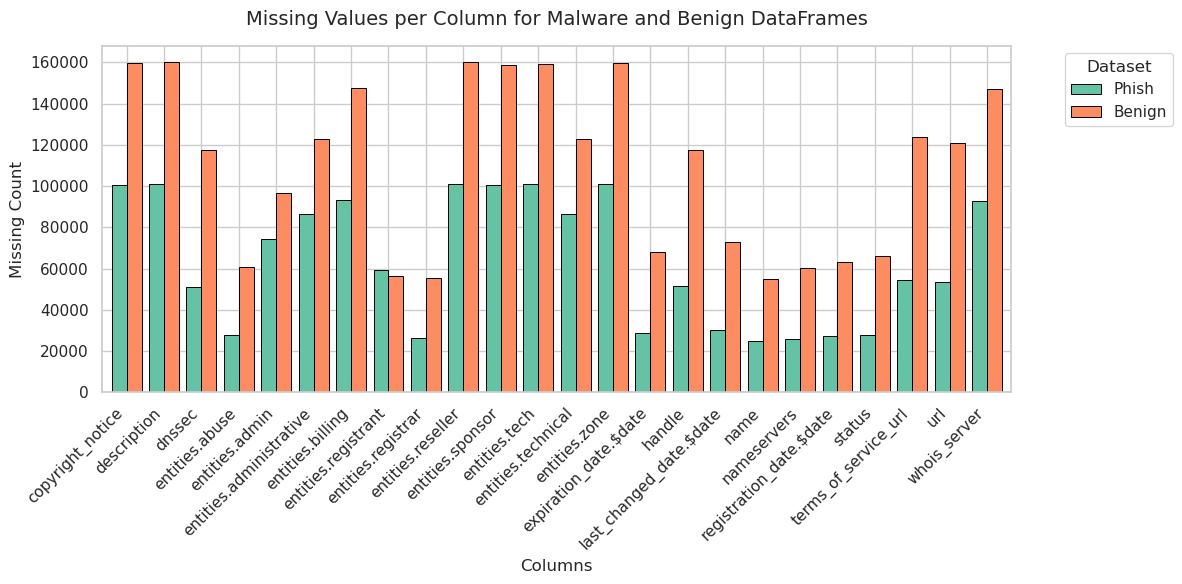

In [17]:
# 1. Calculate missing counts
missing_phish = malware_df.isna().sum()
missing_benign = benign_df.isna().sum()

# 2. Combine the counts into one DataFrame
missing_counts = pd.DataFrame({
    'Phish': missing_phish,
    'Benign': missing_benign
})

# 3. (Optional) Filter to only columns with missing values
missing_counts = missing_counts[(missing_counts['Phish'] > 0) | (missing_counts['Benign'] > 0)]

# 4. Use Seaborn to set a modern style/theme
sns.set_theme(style="whitegrid")

# 5. Create a grouped bar chart
plt.figure(figsize=(12, 6))

# Here, we specify a palette from Seaborn (e.g., "Set2", "husl", "deep", etc.)
# We'll pick two colors from a palette for 'Phish' and 'Benign'.
colors = sns.color_palette("Set2", n_colors=2)

# missing_counts.plot.bar returns an Axes object, so we capture it
ax = missing_counts.plot(
    kind='bar',
    color=colors,
    width=0.8,
    edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize labels and title
ax.set_title("Missing Values per Column for Malware and Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Count", fontsize=12)

# 7. Improve x-axis label rotation and spacing
plt.xticks(rotation=45, ha='right')

# 8. Move the legend outside the plot (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Adjust layout so everything fits
plt.tight_layout()

# 10. Show the plot
plt.show()


<Figure size 1200x600 with 0 Axes>

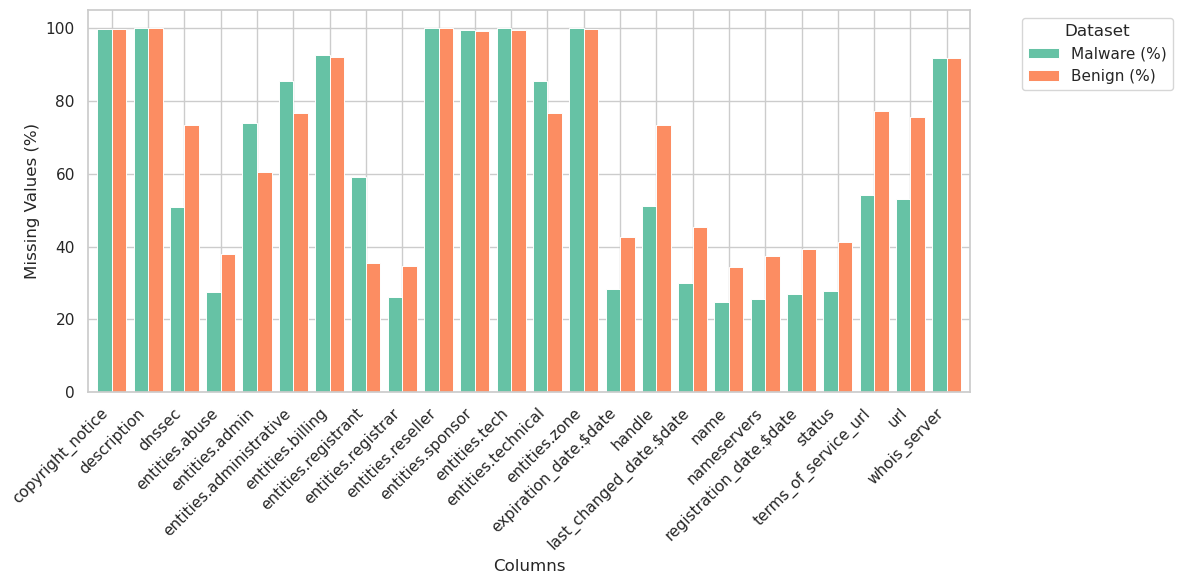

In [18]:
# 1. Calculate the proportion (percentage) of missing values per column
phish_missing_pct = malware_df.isna().sum() / len(malware_df) * 100
benign_missing_pct = benign_df.isna().sum() / len(benign_df) * 100

# 2. Combine into one DataFrame
missing_pct = pd.DataFrame({
    'Malware (%)': phish_missing_pct,
    'Benign (%)': benign_missing_pct
})

# 3. (Optional) Filter to only columns that have missing values in at least one DataFrame
missing_pct = missing_pct[(missing_pct['Malware (%)'] > 0) | (missing_pct['Benign (%)'] > 0)]

# 4. Set a modern Seaborn theme
sns.set_theme(style="whitegrid")

# 5. Plot a grouped bar chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)
ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    # edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize the title and labels
# ax.set_title("Percentage of Missing Values per Column\nMalware vs. Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)

# 7. Improve x-axis label rotation
plt.xticks(rotation=45, ha='right')

# 8. Move the legend (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Tight layout for readability
plt.tight_layout()

# 10. Display the plot
plt.show()


In [19]:
# Function to compute Cohen's h between two proportions
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

results = {}

# Iterate over all columns (assuming both dataframes have the same columns)
for col in benign_df.columns:
    # Calculate the proportion of missing values for each group
    phish_missing_pct = malware_df[col].isna().sum() / len(malware_df)
    benign_missing_pct = benign_df[col].isna().sum() / len(benign_df)
    
    # Calculate Cohen's h (absolute value to focus on the magnitude of the difference)
    h_value = abs(cohens_h(phish_missing_pct, benign_missing_pct))
    
    results[col] = {
        'phish_missing_pct': phish_missing_pct,
        'benign_missing_pct': benign_missing_pct,
        "Cohen's h": h_value
    }

# Create a DataFrame for easier visualization and sort by effect size (largest differences first)
results_df = pd.DataFrame(results).T.sort_values("Cohen's h", ascending=False)
print("Cohen's h and missing percentages for each column:")
print(results_df)

# Set a threshold for a minimal effect size. Here, features with Cohen's h below this value are considered not informative.
threshold = 0.2

# Identify columns that have an effect size smaller than the threshold
features_to_drop = results_df[results_df["Cohen's h"] < threshold].index.tolist()

print("\nFeatures recommended to drop (Cohen's h < {}):".format(threshold))
print(features_to_drop)

Cohen's h and missing percentages for each column:
                         phish_missing_pct  benign_missing_pct  Cohen's h
terms_of_service_url              0.541727            0.772444   0.492703
entities.registrant               0.590007            0.353919   0.477488
url                               0.530865            0.755294   0.474098
dnssec                            0.507792            0.734056   0.471569
handle                            0.510946            0.734619   0.466532
last_changed_date.$date           0.300866            0.454956   0.319418
expiration_date.$date             0.283199            0.426150   0.300244
entities.admin                    0.739726            0.604906   0.288646
status                            0.276979            0.412600   0.286635
registration_date.$date           0.269629            0.393869   0.264942
nameservers                       0.255860            0.375337   0.258134
entities.administrative           0.856005            0.76727

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Helper function to handle arrays
def is_missing(x):
    """
    Return 1 if the value is considered missing, otherwise 0.
    Considers NaN, empty strings (after stripping), empty lists, and empty numpy arrays as missing.
    """
    # Check if x is an array or list and if it's empty
    if isinstance(x, (list, np.ndarray)):
        if len(x) == 0:
            return 1
        else:
            return 0
    # For scalar values, use pd.isna
    if pd.isna(x):
        return 1
    if isinstance(x, str) and x.strip() == "":
        return 1
    return 0

# -------------------------------
# Step 1: Combine the DataFrames
# -------------------------------
# Assume benign_df and malicious_df are your two dataframes.
benign_df['label'] = 0  # 0 for benign
malware_df['label'] = 1  # 1 for malicious

# Combine the two dataframes into one.
df = pd.concat([benign_df, malware_df], ignore_index=True)
print("Combined dataframe shape:", df.shape)

# -----------------------------------------------
# Step 2: Compute Missingness Indicator & Build Contingency Tables
# -----------------------------------------------
# List of columns to analyze (adjust as needed)
cols_to_check = [
    'handle', 'name', 'whois_server', 'terms_of_service_url', 'copyright_notice',
    'description', 'last_changed_date.$date', 'registration_date.$date',
    'expiration_date.$date', 'url', 'entities.registrant', 'entities.abuse',
    'entities.admin', 'entities.registrar', 'nameservers', 'status',
    'entities.technical', 'entities.administrative', 'entities.billing',
    'dnssec', 'entities.sponsor', 'entities.zone', 'entities.tech', 'entities.reseller'
]

# Dictionary to store results
missing_stats = {}

for col in cols_to_check:
    if col in df.columns:
        # Create a temporary missingness indicator series for the column.
        missing_indicator = df[col].apply(is_missing)
        overall_missing_rate = missing_indicator.mean()
        
        # Build a contingency table: rows = missing indicator, columns = label
        contingency = pd.crosstab(missing_indicator, df['label'])
        
        # Run chi-square test if both classes are present in the contingency table.
        if contingency.shape[1] == 2:
            chi2, p, dof, expected = chi2_contingency(contingency)
        else:
            p = 1.0  # Set non-significant if one of the classes is missing.
        
        missing_stats[col] = {
            'overall_missing_rate': overall_missing_rate,
            'chi2_p_value': p,
            'contingency_table': contingency
        }
        
        print(f"Column: {col}")
        print(f"  Overall Missing Rate: {overall_missing_rate:.2f}")
        print(f"  Chi-Square p-value: {p:.4f}")
        print(f"  Contingency Table:\n{contingency}\n")

# ------------------------------------------------------
# Step 3: Decide on Columns to Drop or Retain
# ------------------------------------------------------
# For example, drop columns if overall missing rate is above 90% and p-value > 0.05
columns_to_drop = []

for col, stats in missing_stats.items():
    if stats['overall_missing_rate'] > 0.90 and stats['chi2_p_value'] > 0.05:
        columns_to_drop.append(col)
        print(f"Candidate to drop: {col} (Missing rate: {stats['overall_missing_rate']:.2f}, p-value: {stats['chi2_p_value']:.4f})")

print("\nFinal list of columns to drop based on missingness and statistical test:")
print(columns_to_drop)


Combined dataframe shape: (260809, 26)
Column: handle
  Overall Missing Rate: 0.65
  Chi-Square p-value: 0.0000
  Contingency Table:
label        0      1
handle               
0        42461  49301
1       117539  51508

Column: name
  Overall Missing Rate: 0.31
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0      1
name                
0      104921  75853
1       55079  24956

Column: whois_server
  Overall Missing Rate: 0.92
  Chi-Square p-value: 0.2693
  Contingency Table:
label              0      1
whois_server               
0              12883   8240
1             147117  92569

Column: terms_of_service_url
  Overall Missing Rate: 0.68
  Chi-Square p-value: 0.0000
  Contingency Table:
label                      0      1
terms_of_service_url               
0                      36409  46198
1                     123591  54611

Column: copyright_notice
  Overall Missing Rate: 1.00
  Chi-Square p-value: 0.0233
  Contingency Table:
label                  0       

In [21]:
# Set your missingness threshold (70% in this case)
missing_threshold = 0.70

# Calculate the fraction of missing values for each column in both DataFrames
phish_missing_pct = malware_df.isna().mean()
benign_missing_pct = benign_df.isna().mean()

# Identify columns exceeding the threshold in either dataset
phish_high_missing = phish_missing_pct[phish_missing_pct > missing_threshold].index
benign_high_missing = benign_missing_pct[benign_missing_pct > missing_threshold].index

# Combine into a single set (or list) of columns to drop
features_high_missing = set(phish_high_missing).union(set(benign_high_missing))

print("Features with missingness > 70% in at least one DataFrame:")
print(features_high_missing)


Features with missingness > 70% in at least one DataFrame:
{'dnssec', 'entities.reseller', 'entities.tech', 'entities.technical', 'terms_of_service_url', 'entities.sponsor', 'entities.billing', 'handle', 'entities.admin', 'url', 'entities.administrative', 'entities.zone', 'copyright_notice', 'description', 'whois_server'}


### Inspection of columns which should be dropped according to statistical analysis

In [22]:
for col in features_high_missing:
    print(benign_df[col].value_counts())
    print(malware_df[col].value_counts())
    print("---------------------------------------------------------------")

dnssec
False    39673
True      2878
Name: count, dtype: int64
dnssec
False    48984
True       635
Name: count, dtype: int64
---------------------------------------------------------------
entities.reseller
[{'handle': 'LEX-N-R-5M3-1', 'type': 'entity', 'name': 'CSC Corporate Domains, Inc.', 'email': 'corp-gtld-transfers@cscinfo.com'}]    1
[{'type': 'entity', 'name': 'The Technical Support Department Ltd'}]                                                                  1
[{'handle': 'IMAGINET', 'type': 'entity', 'name': 'Protected Under Privacy Law', 'email': 'Protected Under Privacy Law'}]             1
[{'type': 'entity', 'name': 'Limelight Marketing Communications Ltd'}]                                                                1
[{'type': 'entity', 'name': 'Camb IT Support Ltd'}]                                                                                   1
[{'type': 'entity', 'name': 'GTT'}]                                                                             

In [23]:
benign_df["description"].explode().dropna().unique()
malware_df["copyright_notice"].explode().dropna().value_counts()
# benign_df["copyright_notice"].explode().dropna().value_counts()


copyright_notice
Auteursrechtvoorbehoud: Niets uit deze publicatie mag zonder voorafgaande uitdrukkelijke toestemming van SIDN worden verveelvoudigd, openbaar gemaakt, worden opgeslagen in een gegevensbestand of worden overgezonden, in welke vorm dan ook, elektronisch, mechanisch, door middel van opname of anderszins. Voor registrars geldt dit voorbehoud onverkort, behoudens redelijkerwijs noodzakelijke verveelvoudigingen of openbaarmakingen ten behoeve van de werkzaamheden van registrars, zoals vermeld in de 'Algemene voorwaarden voor registrars'. Elk gebruik van deze informatie voor commerci�le of reclamedoeleinden of soortgelijke activiteiten, is expliciet verboden en tegen overtreding van dat verbod zal worden opgetreden. SIDN verzoekt te worden ge�nformeerd bij constatering van dergelijke activiteiten of enig vermoeden daarvan. � SIDN BV, Auteurswet, geschriftenbescherming (art. 10 lid 1 sub 1)    107
Name: count, dtype: int64

In [24]:
def make_hashable(x):
    """
    Convert x into a hashable type.
    If x is a dict, convert it to a tuple of sorted key-value pairs.
    If x is a list, recursively convert each element.
    Otherwise, return x as-is.
    """
    if isinstance(x, dict):
        # Convert dictionary into a tuple of sorted key-value pairs
        return tuple(sorted((k, make_hashable(v)) for k, v in x.items()))
    elif isinstance(x, list):
        # Convert each element in the list and then make the list a tuple.
        return tuple(make_hashable(item) for item in x)
    else:
        return x

# Iterate over columns_to_drop and display unique values
for col in columns_to_drop:
    # Explode the column (if applicable), drop NA, and convert values to hashable types
    exploded_values = df[col].explode().dropna().apply(make_hashable)
    
    # Now get unique values and their counts
    unique_vals = exploded_values.value_counts()
    
    print(f"Unique values for column '{col}':")
    print(unique_vals)
    print("\n")


Unique values for column 'whois_server':
whois_server
whois.nic.uk                  2045
whois.nic.site                1616
whois.nic.br                  1537
whois.id                      1418
whois.nic.xyz                  961
                              ... 
whois.porkbun.com                1
whois.cira.ca                    1
whois.instra.com                 1
whois.cctld.kg                   1
whois.french-connexion.com       1
Name: count, Length: 244, dtype: int64


Unique values for column 'description':
description
This is a public suffix                                                                                                                          35
The TLD is not associated with, or sponsored by, any national or international government agency or branch of the armed forces in any nation.    34
AsiaInfo                                                                                                                                          1
Copyright © Ilya O. Levi

### Dropping the columns

In [25]:
columns_to_drop = list(features_high_missing) + ['name']
print("Columns to drop:")
print(columns_to_drop)

# Remove 'dnssec' from the list if it exists
if 'dnssec' in columns_to_drop:
    columns_to_drop.remove('dnssec')
    print(columns_to_drop)


# Drop the identified columns from the DataFrame
benign_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
malware_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Replace the Nans in the 'dnssec' column with 'False'
benign_df.loc[:, 'dnssec'] = benign_df['dnssec'].fillna('False')
malware_df.loc[:, 'dnssec'] = malware_df['dnssec'].fillna('False')
# Convert 'dnssec' to boolean
benign_df['dnssec'] = benign_df['dnssec'].astype(bool)
malware_df['dnssec'] = malware_df['dnssec'].astype(bool)

Columns to drop:
['dnssec', 'entities.reseller', 'entities.tech', 'entities.technical', 'terms_of_service_url', 'entities.sponsor', 'entities.billing', 'handle', 'entities.admin', 'url', 'entities.administrative', 'entities.zone', 'copyright_notice', 'description', 'whois_server', 'name']
['entities.reseller', 'entities.tech', 'entities.technical', 'terms_of_service_url', 'entities.sponsor', 'entities.billing', 'handle', 'entities.admin', 'url', 'entities.administrative', 'entities.zone', 'copyright_notice', 'description', 'whois_server', 'name']


In [26]:
render_dataframe(benign_df, max_rows=100, max_cols=50)

,domain_name,last_changed_date.$date,registration_date.$date,expiration_date.$date,entities.registrant,entities.abuse,entities.registrar,nameservers,status,dnssec,label
0,00000fs3085d.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
1,0000100b00e9.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
2,0000100q012c.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
3,0000102n02c4.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
4,0000102n02d5.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
5,0000102n03d3.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
6,0000102n0434.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
7,000010560066.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
8,0000105600be.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0
9,000010640021.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],True,0


In [27]:
render_dataframe(malware_df, max_rows=100, max_cols=50)

,domain_name,last_changed_date.$date,registration_date.$date,expiration_date.$date,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,label
0,irradiateher.com,2023-10-25T09:40:06Z,2022-11-23T13:12:23Z,2024-11-23T13:12:23Z,"[{'handle': '48', 'type': 'entity', 'name': 'eNom, LLC'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['NS1.PUBLICDNSSERVICE.COM', 'NS2.PUBLICDNSSERVICE.COM', 'NS3.PUBLICDNSSERVICE.COM', 'NS4.PUBLICDNSSERVICE.COM']",['client transfer prohibited'],False,nan,1
1,eloquentcs.com,2023-06-16T09:46:02Z,2013-06-13T16:04:43Z,2024-06-13T16:04:43Z,"[{'handle': '146', 'type': 'entity', 'name': 'GoDaddy.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'abuse@godaddy.com'}]","['NS59.DOMAINCONTROL.COM', 'NS60.DOMAINCONTROL.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,1
2,www.neutralsystemsolution.space,2023-08-31T17:10:49Z,2023-06-02T08:35:48Z,2024-06-02T23:59:59Z,[{'name': 'PDR Ltd. d/b/a PublicDomainRegistry.com'}],[{'email': ''}],"['NS1.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM', 'NS2.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM']",['client transfer prohibited'],True,[{'name': 'none'}],1
3,www.drshiwanijainpainclinic.com,2022-10-13T18:35:46Z,2021-08-31T12:20:02Z,2024-08-31T12:20:02Z,"[{'name': 'GoDaddy.com, LLC'}]",[{'email': ''}],"['NS1.DNS-PARKING.COM', 'NS2.DNS-PARKING.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",True,"[{'name': 'Domains By Proxy, LLC'}]",1
4,mkt9136.com,2023-08-11T09:31:50Z,2017-09-12T15:20:17Z,2024-09-12T15:20:17Z,"[{'handle': '292', 'type': 'entity', 'name': 'MarkMonitor Inc.'}]","[{'type': 'entity', 'name': '', 'email': 'abusecomplaints@markmonitor.com'}]","['NS1.ACOUSTIC-ADM.COM', 'NS2.ACOUSTIC-ADM.COM', 'NS3.ACOUSTIC-ADM.COM', 'NS4.ACOUSTIC-ADM.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,1
5,www.ninjacondoms.com,2023-07-28T20:28:00Z,2005-10-22T18:20:32Z,2024-10-22T18:20:32Z,"[{'name': 'OnlineNIC, Inc.'}]",[{'email': ''}],"['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']","['client delete prohibited', 'client transfer prohibited']",True,[{'name': ''}],1
6,gabbyloans.com,2019-10-30T18:13:37Z,2019-10-30T17:42:10Z,2024-10-30T17:42:10Z,"[{'handle': '886', 'type': 'entity', 'name': 'Domain.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'compliance@domain-inc.net'}]","['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']",['active'],False,nan,1
7,www.poczta-polska.e-kei.pl,2021-08-27T14:01:01Z,2013-11-04T12:26:26Z,nan,[{'name': 'cyber_Folks S.A.'}],[{'email': ''}],"['NS1.KEI.PL', 'NS2.KEI.PL']",nan,True,[{'name': ''}],1
8,xinchaocfcddl.org,nan,nan,nan,nan,nan,nan,nan,True,nan,1
9,siwakuposo.com,nan,nan,nan,nan,nan,nan,nan,True,nan,1


In [28]:
# Define the columns to check (all except domain_name, label, and dnssec) if they are all NaN
cols_to_check = [col for col in benign_df.columns if col not in ['domain_name', 'label', 'dnssec']]

# Create a boolean mask that is True when all of the selected columns are NaN for a given row
mask_all_nan_benign = benign_df[cols_to_check].isna().all(axis=1)
mask_all_nan_malware = malware_df[cols_to_check].isna().all(axis=1)

# Count the rows where all these columns are NaN
num_rows_all_nan_benign = mask_all_nan_benign.sum()
num_rows_all_nan_phish = mask_all_nan_malware.sum()

# Print the counts
print("Number of NaN rows in Benign dataframe:", num_rows_all_nan_benign)
print("Number of NaN rows in Malware dataframe:", num_rows_all_nan_phish)
benign_df.drop(index=benign_df[mask_all_nan_benign].index, inplace=True)
malware_df.drop(index=malware_df[mask_all_nan_malware].index, inplace=True)
print(benign_df.shape, malware_df.shape)

Number of NaN rows in Benign dataframe: 55079
Number of NaN rows in Malware dataframe: 25068
(104921, 11) (75741, 11)


In [29]:
benign_df["status"].value_counts()

status
[client transfer prohibited]                                                                                 28292
[ok]                                                                                                         13120
[active]                                                                                                     12196
[client delete prohibited, client renew prohibited, client transfer prohibited, client update prohibited]     6115
[client delete prohibited, client transfer prohibited]                                                        2938
                                                                                                             ...  
[client transfer prohibited, server transfer prohibited, server update prohibited]                               1
[client transfer prohibited, ok, pending delete, server hold]                                                    1
[server hold, client transfer prohibited, client delete prohibited, auto 

In [30]:
columns_to_check = ['entities.abuse', 'entities.registrar', 'entities.registrant', 'entities.admin']  # example column names

for col in columns_to_check:
    unique_keys = set()
    for cell in df[col]:
        if isinstance(cell, list):
            for item in cell:
                if isinstance(item, dict):
                    unique_keys.update(item.keys())
    print(f"Unique keys in '{col}':", unique_keys)


Unique keys in 'entities.abuse': {'email', 'handle', 'type', 'url', 'tel', 'name'}
Unique keys in 'entities.registrar': {'email', 'handle', 'type', 'url', 'tel', 'name', 'whois_server'}
Unique keys in 'entities.registrant': {'email', 'rir', 'handle', 'type', 'url', 'tel', 'name', 'whois_server'}
Unique keys in 'entities.admin': {'name', 'email', 'handle', 'type'}


In [31]:
benign_df["dnssec"].value_counts()

dnssec
True     65248
False    39673
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

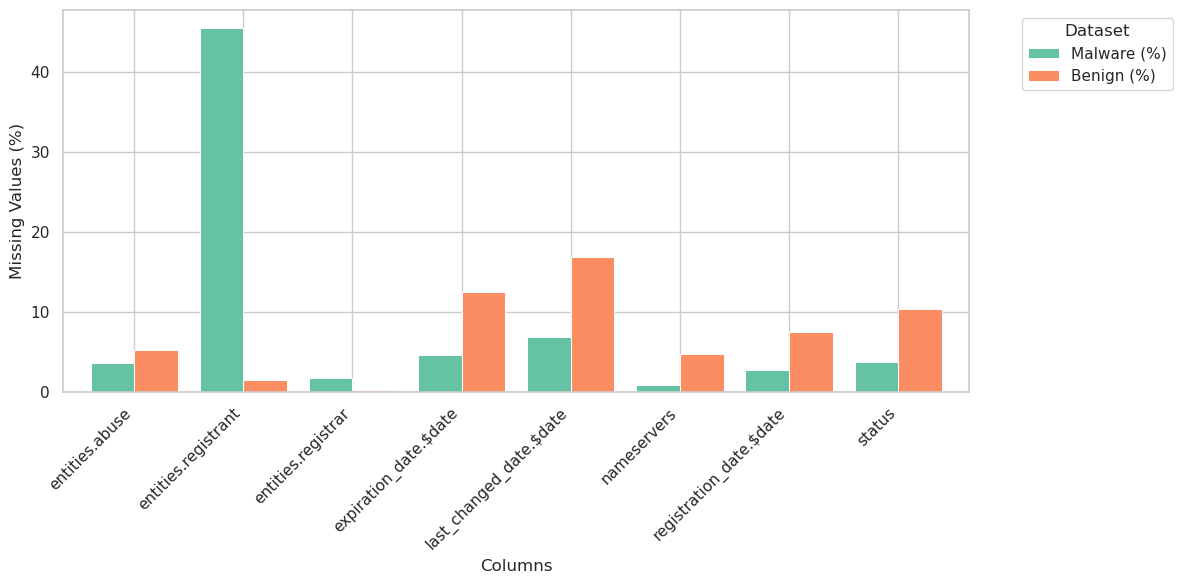

In [32]:
# 1. Calculate the proportion (percentage) of missing values per column
malware_missing_pct = malware_df.isna().sum() / len(malware_df) * 100
benign_missing_pct = benign_df.isna().sum() / len(benign_df) * 100

# 2. Combine into one DataFrame
missing_pct = pd.DataFrame({
    'Malware (%)': malware_missing_pct,
    'Benign (%)': benign_missing_pct
})

# 3. (Optional) Filter to only columns that have missing values in at least one DataFrame
missing_pct = missing_pct[(missing_pct['Malware (%)'] > 0) | (missing_pct['Benign (%)'] > 0)]

# 4. Set a modern Seaborn theme
sns.set_theme(style="whitegrid")

# 5. Plot a grouped bar chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)
ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    # edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize the title and labels
# ax.set_title("Percentage of Missing Values per Column\nMalware vs. Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)

# 7. Improve x-axis label rotation
plt.xticks(rotation=45, ha='right')

# 8. Move the legend (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Tight layout for readability
plt.tight_layout()

# 10. Display the plot
plt.show()


In [33]:
print(malware_df["entities.registrant"].value_counts())
print(benign_df["entities.registrant"].value_counts())

entities.registrant
[{'name': ''}]                                                                                                                                                                    11023
[{'type': 'entity', 'name': 'Privacy service provided by Withheld for Privacy ehf'}]                                                                                               3562
[{'name': 'Privacy service provided by Withheld for Privacy ehf'}]                                                                                                                 2370
[{'type': 'entity'}]                                                                                                                                                               1792
[{'name': 'Domains By Proxy, LLC'}]                                                                                                                                                1596
                                                            

## Prepare the dataframe for trasnformer training
For training the transformer, it is neccessary to create a one concatenated string with fields from analyzed dataframe

In [34]:
def stringify_value(value):
    if isinstance(value, dict):
        return json.dumps(value)
    return str(value) if value else "NA"

def format_entity_entry(entry, canonical_keys):
    kv_pairs = []
    for key in canonical_keys:
        value = entry.get(key, "NA")
        value_str = stringify_value(value)
        if not value_str or value_str == "":
            value_str = "NA"
        kv_pairs.append(f"{key}: {value_str}")
    return " | ".join(kv_pairs)

def process_entity_field(entity_list, canonical_keys, field_label):
    if not entity_list or not isinstance(entity_list, list):
        return f"{field_label}: NA"
    formatted_entries = [format_entity_entry(entry, canonical_keys) for entry in entity_list]
    return f"{field_label}: " + " ; ".join(formatted_entries)

def process_list_field(values, field_label, separator=", "):
    if not values or not isinstance(values, list) or len(values) == 0:
        return f"{field_label}: NA"
    cleaned_values = [str(value).strip() for value in values if value]
    if not cleaned_values:
        return f"{field_label}: NA"
    return f"{field_label}: " + separator.join(cleaned_values)

def concat_rdap_fields(row):
    CLS_TOKEN = "[CLS]"
    SEP_TOKEN = "[SEP]"
    
    tokens = []
    
    # Process the domain_name field.
    domain = row.get("domain_name", "NA").lower().lstrip("www.")
    tokens.append(f"domain: {domain}")
    
    # Define canonical keys for entity fields.
    abuse_keys      = ['name', 'type', 'email', 'url', 'tel', 'handle']
    registrar_keys  = ['name', 'email', 'whois_server', 'url', 'tel', 'handle', 'type']
    registrant_keys = ['name', 'email', 'whois_server', 'url', 'rir', 'tel', 'handle', 'type']
    admin_keys      = ['name', 'email', 'handle', 'type']
    
    # Process dictionary-based entity fields.
    tokens.append(process_entity_field(row.get("entities.abuse", []), abuse_keys, "abuse"))
    tokens.append(process_entity_field(row.get("entities.registrar", []), registrar_keys, "registrar"))
    tokens.append(process_entity_field(row.get("entities.registrant", []), registrant_keys, "registrant"))
    tokens.append(process_entity_field(row.get("entities.admin", []), admin_keys, "admin"))
    
    # Process list-based fields.
    tokens.append(process_list_field(row.get("nameservers", []), "nameservers"))
    tokens.append(process_list_field(row.get("status", []), "status"))
    
    concatenated = f"{CLS_TOKEN} " + f" {SEP_TOKEN} ".join(tokens) + f" {SEP_TOKEN}"
    return concatenated

# Process each dataframe: apply the concatenation function to create an input string.
benign_df['input_string'] = benign_df.apply(concat_rdap_fields, axis=1)
malware_df['input_string'] = malware_df.apply(concat_rdap_fields, axis=1)

# Now, create a combined dataframe with only the columns needed for training.
# Assume each dataframe already contains the 'label' column.
combined_df = pd.concat(
    [benign_df[['input_string', 'label']], malware_df[['input_string', 'label']]],
    ignore_index=True
)

# Optionally, shuffle the combined DataFrame.
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display a few rows of the resulting DataFrame.
render_dataframe(combined_df)


,input_string,label
0,"[CLS] domain: ariake.estate [SEP] abuse: name: NA | type: entity | email: abuse@gmo.jp | url: NA | tel: NA | handle: 576DC194A8684EE79376A6B82064CCFB-DONUTS [SEP] registrar: name: GMO Internet Group, Inc. d/b/a Onamae.com | email: NA | whois_server: NA | url: https://rdap.donuts.co/rdap/entity/49 | tel: NA | handle: 49 | type: entity [SEP] registrant: name: Yoshiaki Ariake | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: entity [SEP] admin: NA [SEP] nameservers: ns1.dns.ne.jp, ns2.dns.ne.jp [SEP] status: active [SEP]",0
1,"[CLS] domain: tjeme.com.mx [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: NEUBOX Internet SA de CV | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: NA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: CAROL.NS.CLOUDFLARE.COM, KURT.NS.CLOUDFLARE.COM [SEP] status: NA [SEP]",1
2,"[CLS] domain: benevolentdifferentlymeadow.com [SEP] abuse: name: NA | type: entity | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: eNom, LLC | email: NA | whois_server: NA | url: NA | tel: NA | handle: 48 | type: entity [SEP] registrant: NA [SEP] admin: NA [SEP] nameservers: NS1.PUBLICDNSSERVICE.COM, NS2.PUBLICDNSSERVICE.COM, NS3.PUBLICDNSSERVICE.COM, NS4.PUBLICDNSSERVICE.COM [SEP] status: client transfer prohibited [SEP]",1
3,"[CLS] domain: micapublicitatesatumare.ro [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: NAMEBOX S.R.L. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: NA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: NS1.NAMEBOX.RO, NS2.NAMEBOX.RO [SEP] status: o k [SEP]",1
4,"[CLS] domain: api.cdnverificationlinks.com [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: Vautron Rechenzentrum AG | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: Registrant State/Province: doonde | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: NS1.ZAP-HOSTING.COM, NS2.ZAP-HOSTING.COM [SEP] status: ok [SEP]",1
5,"[CLS] domain: galwangedi.com [SEP] abuse: name: NA | type: entity | email: abuse@porkbun.com | url: NA | tel: NA | handle: NA [SEP] registrar: name: Porkbun LLC | email: NA | whois_server: NA | url: NA | tel: NA | handle: 1861 | type: entity [SEP] registrant: NA [SEP] admin: NA [SEP] nameservers: NS1.DIGITALOCEAN.COM, NS2.DIGITALOCEAN.COM, NS3.DIGITALOCEAN.COM [SEP] status: client delete prohibited, client transfer prohibited [SEP]",1
6,"[CLS] domain: ssl.prom.st [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: EPAG Domainservices GmbH | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: registrant-name: Sergii Negodiuk (O0011006004) | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: NS1.PROMDNS.NET, NS2.PROMDNS.NET, NS3.PROMDNS.NET [SEP] status: ok [SEP]",0
7,"[CLS] domain: spacepilot.scot [SEP] abuse: name: Abuse Contact | type: entity | email: abuse@corehub.net | url: NA | tel: +34.935275235 | handle: NOT APPLICABLE [SEP] registrar: name: COREhub | email: support@corehub.net | whois_server: NA | url: https://rdap.nic.scot/rdap/entity/15 | tel: +34.935207834 | handle: 15 | type: entity [SEP] registrant: name: NA | email: NA | whois_server: whois.corehub.net | url: https://rdap.nic.scot/rdap/entity/core15OAZLxcC135 | rir: NA | tel: NA | handle: CORE15OAZLXCC135 | type: entity [SEP] admin: NA [SEP] nameservers: dns1.name-services.com, dns2.name-services.com, dns5.name-services.com, dns4.na

In [35]:
# combined_df.info()
# save_path = project_root / "datasets" / "phishing" / "rdap_phishing_preprocessed.csv"
# combined_df.to_csv(save_path, index=False)


In [36]:
save_path = project_root / "datasets" / "malware" / "rdap_malware_preprocessed.csv"
combined_df.to_csv(save_path, index=False)

In [37]:
max_length = combined_df['input_string'].str.len().max()
print(max_length)

948


## Determine the max length of tokens for tokenizer

In [38]:
from transformers import AutoTokenizer

/home/fetagpu/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


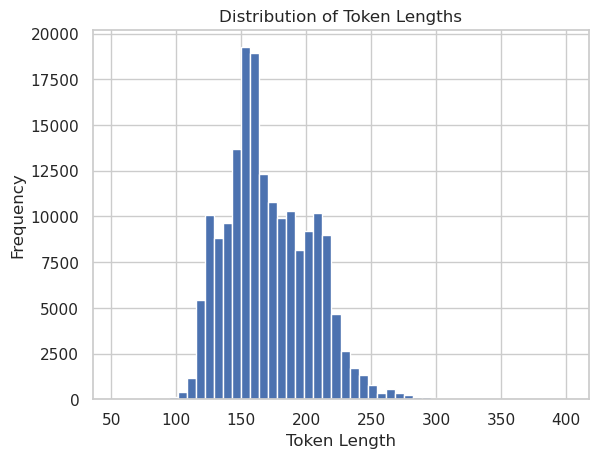

95th percentile: 225.0
99th percentile: 257.0


In [39]:
# Load your tokenizer and a sample of your dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Assume text is in 'input_string' column
token_lengths = combined_df['input_string'].apply(lambda x: len(tokenizer.tokenize(str(x))))

# Plot histogram
plt.hist(token_lengths, bins=50)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths")
plt.show()

# Get percentiles
percentile_95 = np.percentile(token_lengths, 95)
percentile_99 = np.percentile(token_lengths, 99)
print("95th percentile:", percentile_95)
print("99th percentile:", percentile_99)